In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
!pip install keras-core --upgrade
!pip install -q keras-nlp
!pip install seaborn

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [102]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
import os

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.15.0
Keras version: 0.1.7
KerasNLP version: 0.6.4


# Load the Keystroke Logging dataset

In [103]:
DATA_DIR = '/content/drive/MyDrive/DeepData/'

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/DeepData/train_logs.csv
/content/drive/MyDrive/DeepData/test_logs.csv
/content/drive/MyDrive/DeepData/train_scores.csv


In [104]:
df_train_scores = pd.read_csv(DATA_DIR + "train_scores.csv")
df_train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


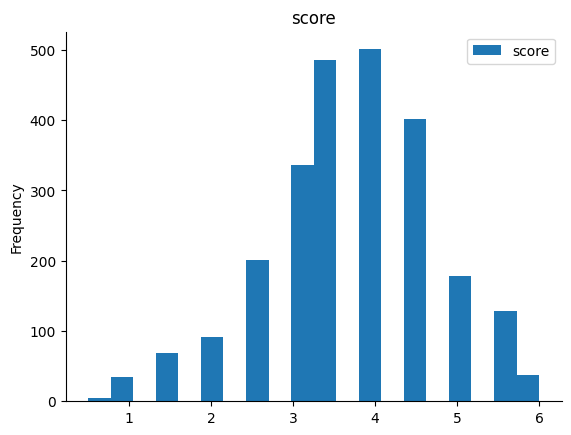

In [105]:
from matplotlib import pyplot as plt
df_train_scores.plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

Text(0.5, 1.0, 'Distribution of scores')

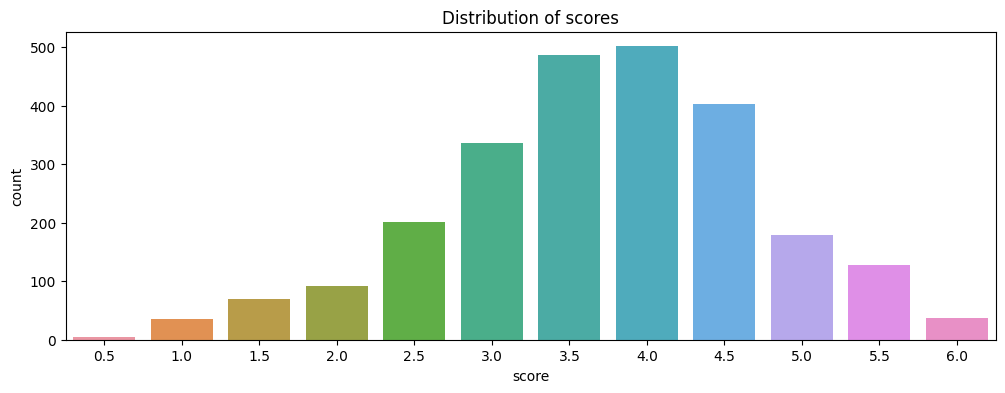

In [106]:
f, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(data=df_train_scores,
                   x="score")

ax.set_title("Distribution of scores")

In [107]:
df_train_logs = pd.read_csv(DATA_DIR + "train_logs.csv")
df_test_logs = pd.read_csv(DATA_DIR + "test_logs.csv")


print(df_train_logs.shape)
print(df_test_logs.shape)
df_train_logs.head()

(8405898, 11)
(6, 11)


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


The average of the number of events per essay in the train dataset is : 1701.0
The average of the number of events per essay in the test dataset is : 2.0


Text(0.5, 0.98, 'Distribution of the number of events per essay - Test dataset')

<Figure size 3000x1800 with 0 Axes>

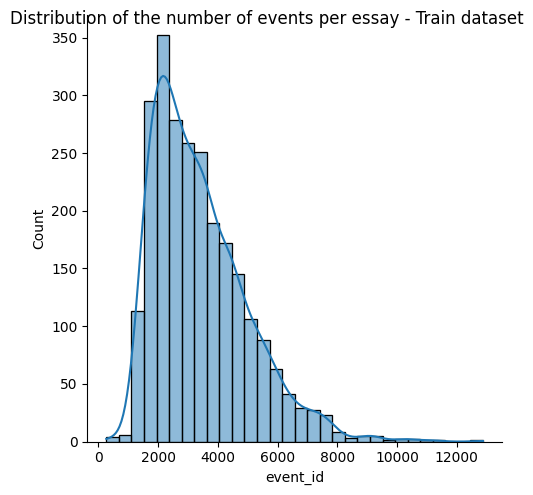

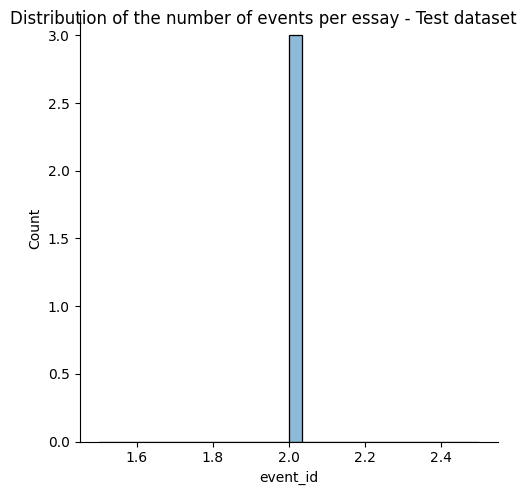

In [108]:
print('The average of the number of events per essay in the train dataset is : ' + str(df_train_logs.groupby("id").mean(numeric_only=True)["event_id"].mean().round(0)))
print('The average of the number of events per essay in the test dataset is : ' + str(df_test_logs.groupby("id").mean(numeric_only=True)["event_id"].mean().round(0)))

fig = plt.figure(figsize=(30,18))
plot = sns.displot(data=df_train_logs[["id","event_id"]].groupby("id").count(),
                 x="event_id", bins=30, kde=True)
plot.fig.suptitle("Distribution of the number of events per essay - Train dataset")

plot = sns.displot(df_test_logs[["id","event_id"]].groupby("id").count(),
                   x="event_id", bins=30, kde=True)
plot.fig.suptitle("Distribution of the number of events per essay - Test dataset")

In [109]:
df_event_count = df_train_logs['up_event'].value_counts().to_frame().reset_index().sort_values(by='up_event',ascending=[False])
df_event_count.columns = ['up_event', 'count']
df_event_count

,up_event,count
0,q,5364789
1,Space,1207128
2,Backspace,964089
3,Shift,334227
4,ArrowRight,121338
...,...,...
117,F1,1
116,k,1
115,Pause,1
114,Â´,1


In [110]:
vocab_event = df_event_count["up_event"].values
vocab_event

array(['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick',
       'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock',
       "'", 'Delete', 'Unidentified', 'Control', '"', '-', '?', ';', '=',
       'Tab', '/', 'Rightclick', ':', '(', ')', '\\', 'ContextMenu',
       'End', '!', 'Meta', 'Alt', 'c', '[', 'v', 'NumLock', 'Insert',
       'Home', 'z', 'a', 'AudioVolumeDown', 'F2', 'x', 't',
       'AudioVolumeUp', '$', 'i', '>', ']', 's', '*', '%', 'w', '&',
       'Dead', 'm', 'Escape', 'ModeChange', 'F3', '<', 'AudioVolumeMute',
       '+', 'o', 'F15', 'ScrollLock', 'PageDown', 'Process', 'h', 'b',
       'e', 'p', '_', 'f', '{', 'PageUp', '`', 'r', '#', '0', '1',
       'Middleclick', 'F12', '5', '\x97', 'OS', '@', 'n', 'y', 'g', 'F11',
       'Ä±', 'MediaTrackNext', 'l', 'Clear', 'MediaPlayPause', 'd', 'V',
       'j', 'u', 'â\x80\x93', '}', '~', 'AltGraph', '2', '|',
       'Unknownclick', 'A', 'MediaTrackPrevious', '^', '\x96', '¿', '¡',
       'M', 'S', '

# Preprocessing data

In [111]:
SEQ_LENGTH = 1700
df_train_prepared_logs = df_train_logs[['id','event_id', 'up_event']][df_train_logs['event_id'] < SEQ_LENGTH]

df_train_prepared_logs = pd.pivot_table(data= df_train_prepared_logs, index='id', columns='event_id', values='up_event', fill_value='', aggfunc='first')
df_train_prepared_logs

event_id,1,2,3,4,5,6,7,8,9,10,...,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699
id,,,,,,,,,,,,,,,,,,,,,
001519c8,Leftclick,Leftclick,Shift,q,q,q,q,q,q,Space,...,q,q,q,q,q,Space,Backspace,.,Space,Space
0022f953,Leftclick,Shift,q,q,q,q,Space,q,q,Space,...,Shift,q,q,q,q,q,q,Space,q,q
0042269b,Leftclick,Shift,q,q,q,q,q,q,q,Space,...,q,q,q,q,q,q,q,Space,q,q
0059420b,Leftclick,Leftclick,Shift,Shift,Shift,Shift,Shift,Shift,Shift,Shift,...,,,,,,,,,,
0075873a,Leftclick,Shift,q,q,q,q,q,q,q,q,...,Space,q,q,q,Space,q,q,q,q,q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb8c745,Leftclick,Tab,Leftclick,Space,Space,Space,Space,Space,Shift,q,...,Backspace,Backspace,Backspace,Backspace,Backspace,Backspace,Backspace,q,q,q
ffbef7e5,Leftclick,Leftclick,Shift,q,q,q,q,Space,q,q,...,q,q,q,q,q,.,Space,Shift,q,Space
ffccd6fd,Leftclick,Leftclick,q,q,q,q,q,q,Space,q,...,Space,Space,Space,Space,Space,Space,Space,Space,Space,Space


In [112]:
df_train_prepared_logs["text"] = ""
for i in range(1, 1700):
    df_train_prepared_logs["text"] = df_train_prepared_logs["text"] + " " + df_train_prepared_logs[i]

df_train_prepared_logs["text"] = df_train_prepared_logs["text"].apply(lambda x : x.strip())
df_train_prepared_logs

event_id,1,2,3,4,5,6,7,8,9,10,...,1691,1692,1693,1694,1695,1696,1697,1698,1699,text
id,,,,,,,,,,,,,,,,,,,,,
001519c8,Leftclick,Leftclick,Shift,q,q,q,q,q,q,Space,...,q,q,q,q,Space,Backspace,.,Space,Space,Leftclick Leftclick Shift q q q q q q Space q ...
0022f953,Leftclick,Shift,q,q,q,q,Space,q,q,Space,...,q,q,q,q,q,q,Space,q,q,Leftclick Shift q q q q Space q q Space Shift ...
0042269b,Leftclick,Shift,q,q,q,q,q,q,q,Space,...,q,q,q,q,q,q,Space,q,q,Leftclick Shift q q q q q q q Space q q q Spac...
0059420b,Leftclick,Leftclick,Shift,Shift,Shift,Shift,Shift,Shift,Shift,Shift,...,,,,,,,,,,Leftclick Leftclick Shift Shift Shift Shift Sh...
0075873a,Leftclick,Shift,q,q,q,q,q,q,q,q,...,q,q,q,Space,q,q,q,q,q,Leftclick Shift q q q q q q q q q q q Space q ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb8c745,Leftclick,Tab,Leftclick,Space,Space,Space,Space,Space,Shift,q,...,Backspace,Backspace,Backspace,Backspace,Backspace,Backspace,q,q,q,Leftclick Tab Leftclick Space Space Space Spac...
ffbef7e5,Leftclick,Leftclick,Shift,q,q,q,q,Space,q,q,...,q,q,q,q,.,Space,Shift,q,Space,Leftclick Leftclick Shift q q q q Space q q q ...
ffccd6fd,Leftclick,Leftclick,q,q,q,q,q,q,Space,q,...,Space,Space,Space,Space,Space,Space,Space,Space,Space,Leftclick Leftclick q q q q q q Space q q q q ...


In [113]:
vocab = vocab_event.tolist()
VOCAB_SIZE = len(vocab)

# After this layer, we have a tensor of shape (batch_size, max_len) containing vocab indices.
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens = len(vocab) + 2,
                                 output_mode='int',
                                 standardize=None,
                                 split="whitespace",
                                 vocabulary=vocab,
                                 output_sequence_length=1700)

vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'q',
 'Space',
 'Backspace',
 'Shift',
 'ArrowRight',
 'Leftclick',
 'ArrowLeft',
 '.',
 ',',
 'ArrowDown',
 'ArrowUp',
 'Enter',
 'CapsLock',
 "'",
 'Delete',
 'Unidentified',
 'Control',
 '"',
 '-',
 '?',
 ';',
 '=',
 'Tab',
 '/',
 'Rightclick',
 ':',
 '(',
 ')',
 '\\',
 'ContextMenu',
 'End',
 '!',
 'Meta',
 'Alt',
 'c',
 '[',
 'v',
 'NumLock',
 'Insert',
 'Home',
 'z',
 'a',
 'AudioVolumeDown',
 'F2',
 'x',
 't',
 'AudioVolumeUp',
 '$',
 'i',
 '>',
 ']',
 's',
 '*',
 '%',
 'w',
 '&',
 'Dead',
 'm',
 'Escape',
 'ModeChange',
 'F3',
 '<',
 'AudioVolumeMute',
 '+',
 'o',
 'F15',
 'ScrollLock',
 'PageDown',
 'Process',
 'h',
 'b',
 'e',
 'p',
 '_',
 'f',
 '{',
 'PageUp',
 '`',
 'r',
 '#',
 '0',
 '1',
 'Middleclick',
 'F12',
 '5',
 '\x97',
 'OS',
 '@',
 'n',
 'y',
 'g',
 'F11',
 'Ä±',
 'MediaTrackNext',
 'l',
 'Clear',
 'MediaPlayPause',
 'd',
 'V',
 'j',
 'u',
 'â\x80\x93',
 '}',
 '~',
 'AltGraph',
 '2',
 '|',
 'Unknownclick',
 'A',
 'MediaTrackPrevious',
 '^',
 '\x96',

In [114]:
# Create the x and y
X_train = vectorize_layer(df_train_prepared_logs["text"])

len_df_train = df_train_prepared_logs["text"].shape[0]
y_train = tf.reshape(tf.convert_to_tensor(df_train_scores["score"].values), (len_df_train, 1))


# Create the model

In [115]:

import tensorflow as tf
from tensorflow import keras


token_id_input = keras.Input(shape=(SEQ_LENGTH,), dtype=tf.int32)


outputs_tok_pos_emb = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LENGTH,
    embedding_dim=32,
)(token_id_input)

outputs_transf_enc1 = keras_nlp.layers.TransformerEncoder(num_heads=6,
                                                         intermediate_dim=128,
                                                         dropout=0.1)(outputs_tok_pos_emb)
outputs_transf_enc2 = keras_nlp.layers.TransformerEncoder(num_heads=6,
                                                         intermediate_dim=128,
                                                         dropout=0.1)(outputs_transf_enc1)
outputs_transf_enc3 = keras_nlp.layers.TransformerEncoder(num_heads=6,
                                                         intermediate_dim=128,
                                                         dropout=0.1)(outputs_transf_enc2)

outputs = keras.layers.Dense(1)(outputs_transf_enc3[:, 0, :])


model = keras.Model(
    inputs=token_id_input,
    outputs=outputs,
)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1700)]            0         
                                                                 
 token_and_position_embeddi  (None, 1700, 32)          58560     
 ng_4 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_encoder_12 (Tr  (None, 1700, 32)          12442     
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_13 (Tr  (None, 1700, 32)          12442     
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_14 (Tr  (None, 1700, 32)          1244

In [116]:
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.AdamW(5e-4),
    metrics=['mean_squared_error'],
    jit_compile=True,
)

model.fit(
    batch_size=32,
    shuffle=True,
    x = X_train,
    y = y_train,
    epochs=80
)

Epoch 1/80
78/78 [==============================] - 112s 1s/step - loss: 1.1743 - mean_squared_error: 1.1743
Epoch 2/80
78/78 [==============================] - 86s 1s/step - loss: 0.8936 - mean_squared_error: 0.8936
Epoch 3/80
78/78 [==============================] - 86s 1s/step - loss: 0.8040 - mean_squared_error: 0.8040
Epoch 4/80
78/78 [==============================] - 86s 1s/step - loss: 0.7131 - mean_squared_error: 0.7131
Epoch 5/80
78/78 [==============================] - 86s 1s/step - loss: 0.5940 - mean_squared_error: 0.5940
Epoch 6/80
78/78 [==============================] - 86s 1s/step - loss: 0.5326 - mean_squared_error: 0.5326
Epoch 7/80
78/78 [==============================] - 86s 1s/step - loss: 0.4476 - mean_squared_error: 0.4476
Epoch 8/80
78/78 [==============================] - 86s 1s/step - loss: 0.3855 - mean_squared_error: 0.3855
Epoch 9/80
78/78 [==============================] - 86s 1s/step - loss: 0.3551 - mean_squared_error: 0.3551
Epoch 10/80
78/78 [========

In [117]:
for tok, score, idx in zip(X_train, y_train, range(15)):
    print(score.numpy(), np.around(model.predict(tf.expand_dims(tok, axis=0))[0], decimals=1))


1/1 [==============================] - 1s 1s/step
[3.5] [3.7]
1/1 [==============================] - 0s 18ms/step
[3.5] [3.4]
1/1 [==============================] - 0s 17ms/step
[6.] [6.1]
1/1 [==============================] - 0s 20ms/step
[2.] [2.2]
1/1 [==============================] - 0s 19ms/step
[4.] [4.1]
1/1 [==============================] - 0s 18ms/step
[2.] [2.1]
1/1 [==============================] - 0s 18ms/step
[4.5] [4.6]
1/1 [==============================] - 0s 19ms/step
[4.] [4.1]
1/1 [==============================] - 0s 19ms/step
[3.5] [3.4]
1/1 [==============================] - 0s 19ms/step
[4.5] [4.6]
1/1 [==============================] - 0s 21ms/step
[4.5] [4.5]
1/1 [==============================] - 0s 20ms/step
[2.5] [2.8]
1/1 [==============================] - 0s 18ms/step
[4.5] [4.6]
1/1 [==============================] - 0s 20ms/step
[3.5] [3.6]
1/1 [==============================] - 0s 18ms/step
[2.5] [2.5]


78/78 [==============================] - 17s 217ms/step


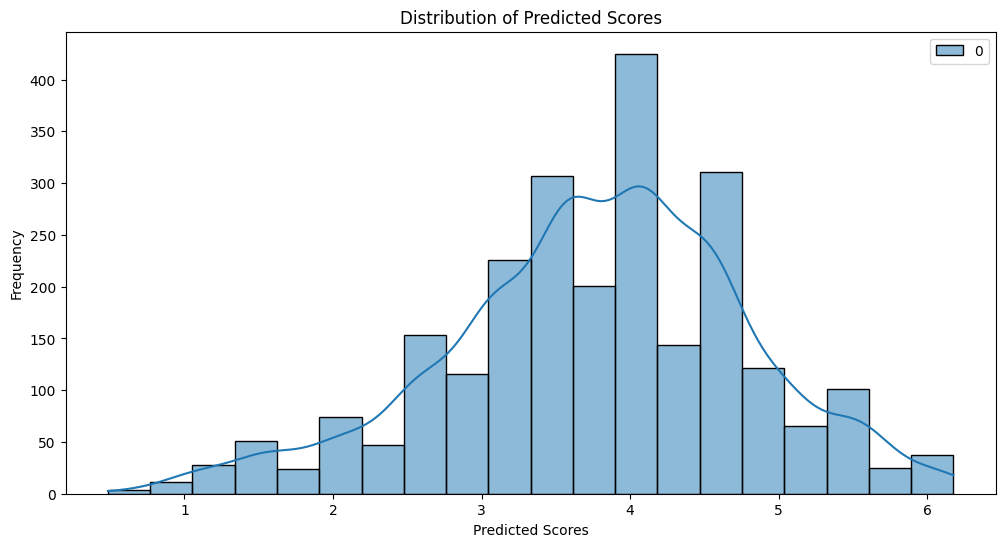

In [118]:
# Distribution of predicted scores
plt.figure(figsize=(12, 6))
sns.histplot(model.predict(X_train), bins=20, kde=True)
plt.title('Distribution of Predicted Scores')
plt.xlabel('Predicted Scores')
plt.ylabel('Frequency')
plt.show()

In [119]:
df_test_prepared_logs = pd.pivot_table(data= df_test_logs, index='id', columns='event_id', values='up_event', fill_value='', aggfunc='first')

df_test_prepared_logs["text"] = ""
for i in range(1, 3):
    df_test_prepared_logs["text"] = df_test_prepared_logs["text"] + " " + df_test_prepared_logs[i]

df_test_prepared_logs["text"] = df_test_prepared_logs["text"].apply(lambda x : x.strip())

test_token_ids = vectorize_layer(df_test_prepared_logs["text"])
test_token_ids

<tf.Tensor: shape=(3, 1700), dtype=int64, numpy=
array([[3, 3, 0, ..., 0, 0, 0],
       [2, 2, 0, ..., 0, 0, 0],
       [3, 2, 0, ..., 0, 0, 0]])>

In [120]:
print(model.predict(test_token_ids))

1/1 [==============================] - 1s 599ms/step
[[0.5272884 ]
 [0.4876543 ]
 [0.52751744]]
